In [1]:
import numpy as np
import pandas as pd
from skimage.transform import resize
data_path = '/home/richard/Documents/dslab/data/'

### Prepare patches

In [17]:
# load data set in .npy format
X = np.load(data_path + '03_features/fulldataset_small_mvt_1.npy', allow_pickle=True)
X_df = pd.DataFrame(X)

In [18]:
pd.DataFrame(X_df[0].iloc[0]).head()

,droplet_id,frame,center_row,center_col,radius,nr_cells,patch,cell_signals
0,0,0,595,114,21,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."
1,1,0,1233,4140,21,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."
2,2,0,2395,2659,21,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."
3,3,0,2644,3738,21,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."
4,4,0,1665,1987,22,0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","Empty DataFrame Columns: [cell_id, center_row,..."


In [75]:
len(X_df[0])

8

### Prepare tracking  

In [4]:
# read csv into dataframe
tracking_df = pd.read_csv(data_path + '05_results/tracking_small_mvt_1.csv')
initial_len = len(tracking_df)
print('Initial length: ', initial_len)

Initial length:  59239


In [9]:
# there is no Nans here, was checked
tracking_df.head()

,framePrev,frameNext,dropletIdPrev,dropletIdNext
0,0,1,0,3473
1,0,1,1,7477
2,0,1,2,4783
3,0,1,3,7496
4,0,1,4,8326


### Debugging

In [5]:
def create_mapping(patches_df, tracking_df, regions=None):

    mapping = None
    columns = ["dropletIdNext"]
    num_frames = len(patches_df[0])
    
    for i in range(num_frames-1):

        # get frames
        frame2 = pd.DataFrame(patches_df[0].iloc[i+1])

        # drop nan values and rows with no cells
        frame2 = frame2.dropna()
        frame2 = frame2[frame2["nr_cells"] > 0]
        frame2 = frame2.rename(columns={'patch': 'patch' + str(i+1)})

        if mapping is None:
            
            mapping = tracking_df[tracking_df["framePrev"] == i]

            # drop nan values and rows with no cells
            frame1 = pd.DataFrame(patches_df[0].iloc[i])
            frame1 = frame1.dropna()
            frame1 = frame1[frame1["nr_cells"] > 0]
            frame1 = frame1.rename(columns={'patch': 'patch' + str(i)})
            columns.append('patch' + str(i))

            mapping = mapping.merge(frame1, how="inner", left_on="dropletIdPrev", right_on="droplet_id")
        
        else:
            # join next frame
            mapping = mapping.merge(tracking_df[tracking_df["framePrev"] == i], \
                                    how="inner", left_on="dropletIdNext", \
                                    right_on="dropletIdPrev",  suffixes=("_x", None))

        columns.append('patch' + str(i+1))

        mapping = mapping.merge(frame2, how="inner", left_on="dropletIdNext", right_on="droplet_id")

        mapping = mapping.dropna()
        mapping = mapping[columns]
    
    columns = columns[1:]
    
    return mapping[columns]

In [6]:
res = create_mapping(X_df, tracking_df)

In [7]:
res.head()

,patch0,patch1,patch2,patch3,patch4,patch5,patch6,patch7
0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [38]:
# compute average size of numpy arrays in patch
c = 0

for i in range(len(frame1)):
    c += frame1["patch0"].iloc[i].shape[1]

print(c/len(frame1))


40.03004807692308


In [25]:
def turn_to_numpy(df):
    
    dataset = None

    for i in range(len(df.columns)):

        if i == 0:
            dataset = resize_patch_column(df[df.columns[i]])

        else:
            dataset = np.concatenate((dataset, resize_patch_column(df[df.columns[i]])), axis=1)

    return dataset

# resizes all patches to 40x40
def resize_patch_column(df):

    resized = np.empty((len(df),1, 2, 40, 40))
    
    for i in range(len(df)):

        patch = df.iloc[i]
        patch = resize(patch, (2,40,40))
        patch = np.expand_dims(patch, axis=0)

        resized[i] = patch

    return resized

In [16]:
res.iloc[0][0].shape

(2, 39, 39)

In [24]:
res[res.columns[0]].iloc[0].shape

(2, 39, 39)

In [17]:
a = resize(res.iloc[0][0], (2,40,40))

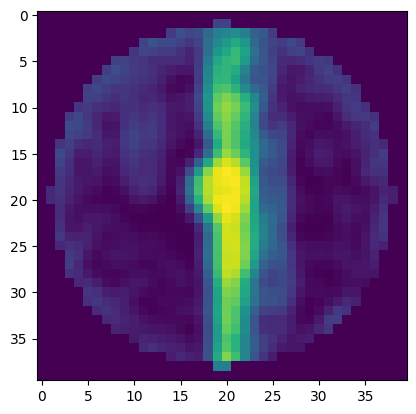

In [19]:
plt.imshow(a[0])
plt.show()

In [26]:
arr = turn_to_numpy(res)

In [28]:
arr.shape

(3041, 8, 2, 40, 40)

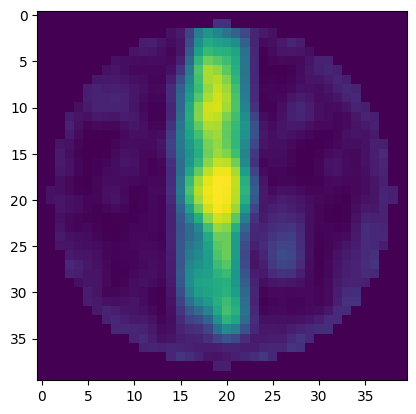

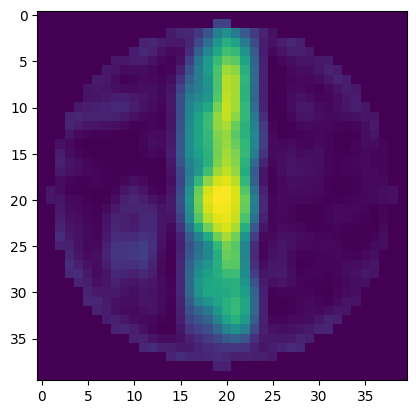

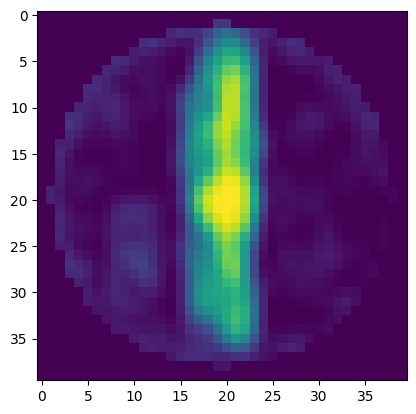

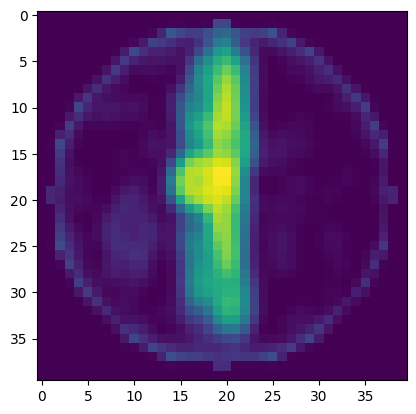

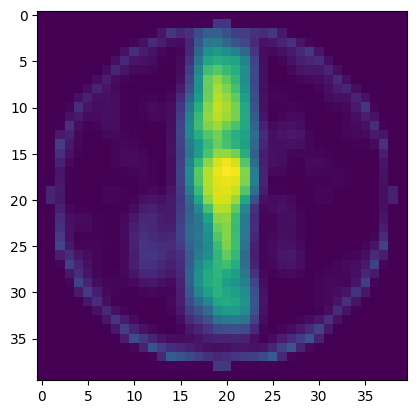

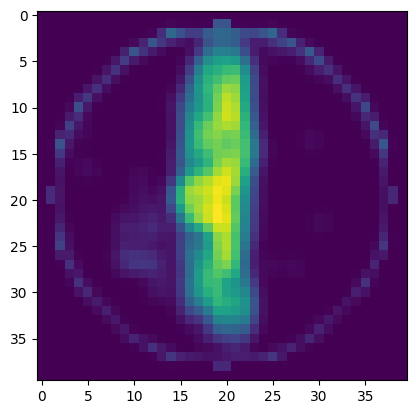

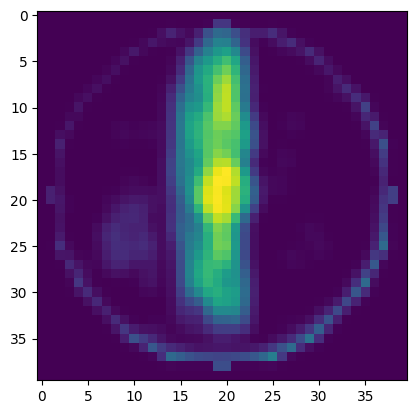

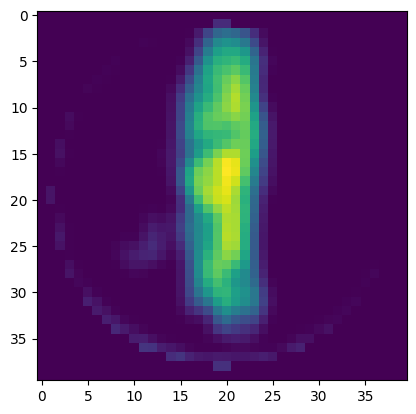

In [32]:
# plot 5 first patches
import matplotlib.pyplot as plt

for i in range(8):
    plt.imshow(arr[2][i][0])
    plt.show()